In [5]:
import torch
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import os

# -------------------- Image preprocessing --------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# -------------------- Load dataset --------------------
# For Stage 1: Fruit vs Vegetable
train_dataset_stage1 = ImageFolder("..\\data\\raw\\train", transform=transform)
test_dataset_stage1  = ImageFolder("..\\data\\raw\\test", transform=transform)

train_loader_stage1 = DataLoader(train_dataset_stage1, batch_size=32, shuffle=False)
test_loader_stage1  = DataLoader(test_dataset_stage1, batch_size=32, shuffle=False)

# For Stage 2: Fine-grained classes
# Flatten subfolders: each fruit/vegetable type becomes a top-level folder
# Example structure:
# train_stage2/
#   apple/
#   banana/
#   carrot/
#   potato/
train_dataset_stage2 = ImageFolder("..\\data\\stage2_train", transform=transform)
test_dataset_stage2  = ImageFolder("..\\data\\stage2_test", transform=transform)

train_loader_stage2 = DataLoader(train_dataset_stage2, batch_size=32, shuffle=False)
test_loader_stage2  = DataLoader(test_dataset_stage2, batch_size=32, shuffle=False)

# -------------------- Class names --------------------
# Stage 1
print("Stage 1 classes (Fruit vs Vegetable):", train_dataset_stage1.classes)

# Stage 2
print("Stage 2 classes (Fine-grained):", train_dataset_stage2.classes)


Stage 1 classes (Fruit vs Vegetable): ['fruit', 'vegetable']
Stage 2 classes (Fine-grained): ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


In [7]:
# Load pretrained MobileNetV2
model = models.mobilenet_v2(pretrained=True)
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
feature_extractor.eval()  # freeze weights

# Function to extract features
def extract_features(loader):
    features_list, labels_list = [], []
    with torch.no_grad():
        for images, labels in loader:
            outputs = feature_extractor(images)
            outputs = outputs.view(outputs.size(0), -1)
            features_list.append(outputs.numpy())
            labels_list.append(labels.numpy())
    return np.concatenate(features_list), np.concatenate(labels_list)

# Stage 1 features
X_train_stage1, y_train_stage1 = extract_features(train_loader_stage1)
X_test_stage1, y_test_stage1   = extract_features(test_loader_stage1)

# Stage 2 features (flattened folders)
X_train_stage2, y_train_stage2 = extract_features(train_loader_stage2)
X_test_stage2, y_test_stage2   = extract_features(test_loader_stage2)

c:\Users\Hams\Downloads\machine-learning\MLproject\fruit_veg_classifier\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hams\Downloads\machine-learning\MLproject\fruit_veg_classifier\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Hams\Downloads\machine-learning\MLproject\fruit_veg_classifier\venv\lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [9]:
# Stage 1 classes (Fruit vs Vegetable)
print(train_dataset_stage1.classes)
print(test_dataset_stage1.classes)

# Stage 2 classes (Fine-grained, flattened folders)
print(train_dataset_stage2.classes)
print(test_dataset_stage2.classes)


['fruit', 'vegetable']
['fruit', 'vegetable']
['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']
['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


In [10]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# -------------------- Stage 1: Fruit vs Vegetable --------------------
# Map 'fruit' -> 0, 'vegetable' -> 1
label_mapping = { 'fruit': 0, 'vegetable': 1 }

# Map numeric targets from Stage 1 dataset
y_train_stage1 = np.array([label_mapping[train_dataset_stage1.classes[l]] for l in y_train_stage1])
y_test_stage1  = np.array([label_mapping[test_dataset_stage1.classes[l]] for l in y_test_stage1])

# Verify both classes exist
print("Unique Stage 1 labels in training set:", np.unique(y_train_stage1))
print("Unique Stage 1 labels in test set:", np.unique(y_test_stage1))

# Train LinearSVC for Stage 1
stage1_clf = LinearSVC(C=1.0, max_iter=5000)
stage1_clf.fit(X_train_stage1, y_train_stage1)  # <-- use correct features

# Predict Stage 1
y_pred_stage1 = stage1_clf.predict(X_test_stage1)  # <-- use correct features

# Evaluate Stage 1
print("Stage 1 Accuracy (Fruit vs Vegetable):", accuracy_score(y_test_stage1, y_pred_stage1))
print("Stage 1 Confusion Matrix:\n", confusion_matrix(y_test_stage1, y_pred_stage1))
print("Stage 1 Classification Report:\n", classification_report(
    y_test_stage1, y_pred_stage1, target_names=['Fruit','Vegetable']))


Unique Stage 1 labels in training set: [0 1]
Unique Stage 1 labels in test set: [0 1]
Stage 1 Accuracy (Fruit vs Vegetable): 0.9554317548746518
Stage 1 Confusion Matrix:
 [[ 76  13]
 [  3 267]]
Stage 1 Classification Report:
               precision    recall  f1-score   support

       Fruit       0.96      0.85      0.90        89
   Vegetable       0.95      0.99      0.97       270

    accuracy                           0.96       359
   macro avg       0.96      0.92      0.94       359
weighted avg       0.96      0.96      0.95       359



In [11]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# -------------------- Stage 1: Fruit vs Vegetable --------------------
# Map 'fruit' -> 0, 'vegetable' -> 1
label_mapping = {'fruit': 0, 'vegetable': 1}

# Map numeric targets from Stage 1 dataset
y_train_stage1 = np.array([label_mapping[train_dataset_stage1.classes[l]] for l in y_train_stage1])
y_test_stage1  = np.array([label_mapping[test_dataset_stage1.classes[l]] for l in y_test_stage1])

# Verify both classes exist
print("Unique Stage 1 labels in training set:", np.unique(y_train_stage1))
print("Unique Stage 1 labels in test set:", np.unique(y_test_stage1))

# Train LinearSVC
stage1_clf = LinearSVC(C=1.0, max_iter=5000)
stage1_clf.fit(X_train_stage1, y_train_stage1)  # use Stage 1 features

# Predict Stage 1
y_pred_stage1 = stage1_clf.predict(X_test_stage1)

# Evaluate Stage 1
print("Stage 1 Accuracy (Fruit vs Vegetable):", accuracy_score(y_test_stage1, y_pred_stage1))
print("Stage 1 Confusion Matrix:\n", confusion_matrix(y_test_stage1, y_pred_stage1))
print("Stage 1 Classification Report:\n", classification_report(
    y_test_stage1, y_pred_stage1, target_names=['Fruit','Vegetable']))


Unique Stage 1 labels in training set: [0 1]
Unique Stage 1 labels in test set: [0 1]
Stage 1 Accuracy (Fruit vs Vegetable): 0.9554317548746518
Stage 1 Confusion Matrix:
 [[ 76  13]
 [  3 267]]
Stage 1 Classification Report:
               precision    recall  f1-score   support

       Fruit       0.96      0.85      0.90        89
   Vegetable       0.95      0.99      0.97       270

    accuracy                           0.96       359
   macro avg       0.96      0.92      0.94       359
weighted avg       0.96      0.96      0.95       359



In [12]:
print("Unique fruit classes in training set:", np.unique(y_train_fruit))
print("Unique vegetable classes in training set:", np.unique(y_train_veg))


Unique fruit classes in training set: [0]
Unique vegetable classes in training set: [1]


In [12]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# -------------------- Stage 2: Fine-Grained Classification --------------------

# Optional: Reduce feature dimensions for faster SVM
pca = PCA(n_components=512)  # you can adjust this
X_train_stage2_pca = pca.fit_transform(X_train_stage2)
X_test_stage2_pca  = pca.transform(X_test_stage2)

# Train LinearSVC on all fine-grained classes
stage2_clf = LinearSVC(C=1.0, max_iter=5000)
stage2_clf.fit(X_train_stage2_pca, y_train_stage2)

# Predict Stage 2
y_pred_stage2 = stage2_clf.predict(X_test_stage2_pca)

# Evaluate Stage 2
print("Stage 2 Accuracy (Fine-Grained Classes):", accuracy_score(y_test_stage2, y_pred_stage2))
print("Stage 2 Confusion Matrix:\n", confusion_matrix(y_test_stage2, y_pred_stage2))
print("Stage 2 Classification Report:\n", classification_report(y_test_stage2, y_pred_stage2,
      target_names=train_dataset_stage2.classes))


Stage 2 Accuracy (Fine-Grained Classes): 0.9721448467966574
Stage 2 Confusion Matrix:
 [[ 8  0  0 ...  0  0  0]
 [ 2  7  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0 10]]
Stage 2 Classification Report:
                precision    recall  f1-score   support

        apple       0.73      0.80      0.76        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.90      0.90      0.90        10
      cabbage       1.00      1.00      1.00        10
     capsicum       0.90      0.90      0.90        10
       carrot       1.00      0.90      0.95        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      1.00      1.00        10
         corn       0.90      0.90      0.90        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       ga

c:\Users\Hams\Downloads\machine-learning\MLproject\fruit_veg_classifier\venv\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [13]:
# -------------------- Final Predictions --------------------
# Use Stage 2 predictions as final output
y_final_pred = y_pred_stage2  # from Stage 2 SVM

# Evaluate final predictions
final_accuracy = accuracy_score(y_test_stage2, y_final_pred)
final_cm = confusion_matrix(y_test_stage2, y_final_pred)
final_report = classification_report(y_test_stage2, y_final_pred, target_names=train_dataset_stage2.classes)

print("Final End-to-End Accuracy:", final_accuracy)
print("Final Confusion Matrix:\n", final_cm)
print("Final Classification Report:\n", final_report)

# Optional: view first 10 predictions vs true labels
print("Sample predictions (first 10):")
for i in range(10):
    print(f"Predicted: {train_dataset_stage2.classes[y_final_pred[i]]}, True: {train_dataset_stage2.classes[y_test_stage2[i]]}")


Final End-to-End Accuracy: 0.9721448467966574
Final Confusion Matrix:
 [[ 8  0  0 ...  0  0  0]
 [ 2  7  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0 10]]
Final Classification Report:
                precision    recall  f1-score   support

        apple       0.73      0.80      0.76        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.90      0.90      0.90        10
      cabbage       1.00      1.00      1.00        10
     capsicum       0.90      0.90      0.90        10
       carrot       1.00      0.90      0.95        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      1.00      1.00        10
         corn       0.90      0.90      0.90        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8956583..2.64].


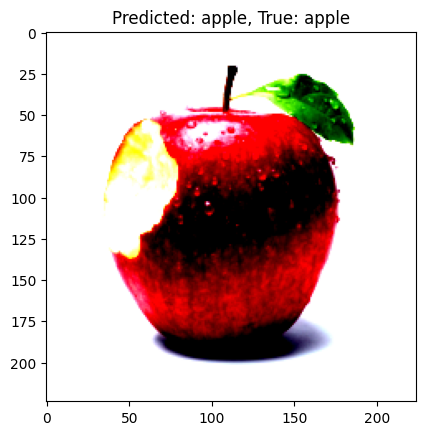

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8956583..2.64].


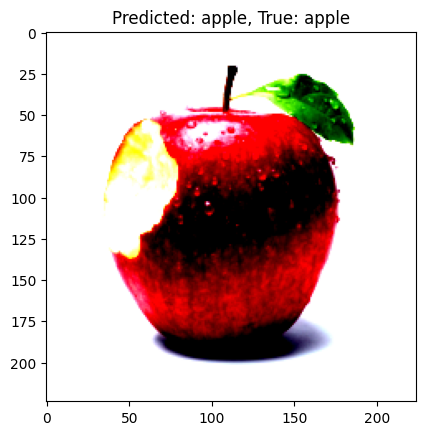

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


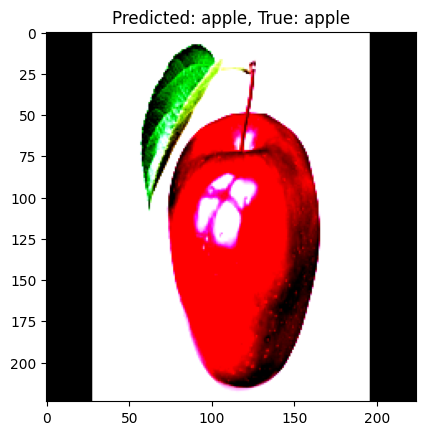

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9481792..2.5528543].


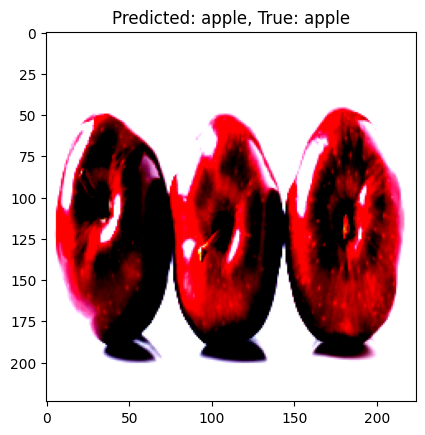

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.1519828].


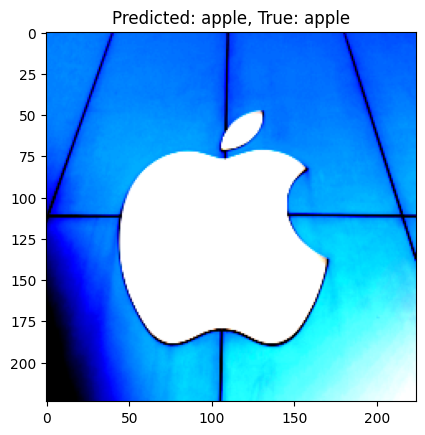

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


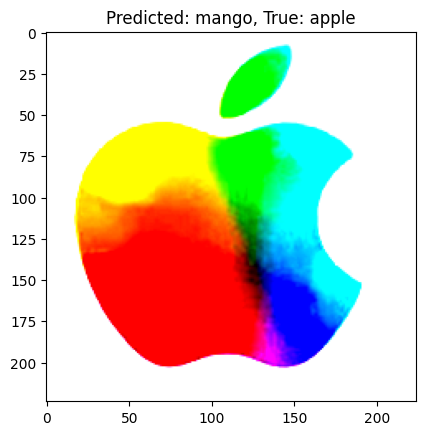

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2146587].


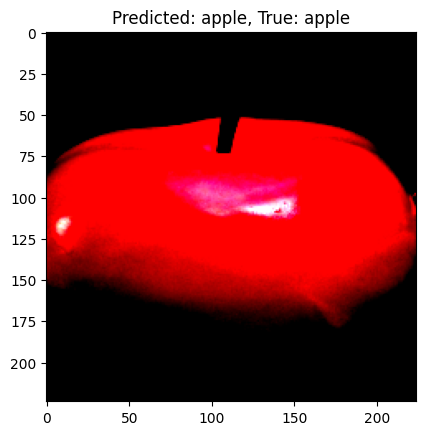

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


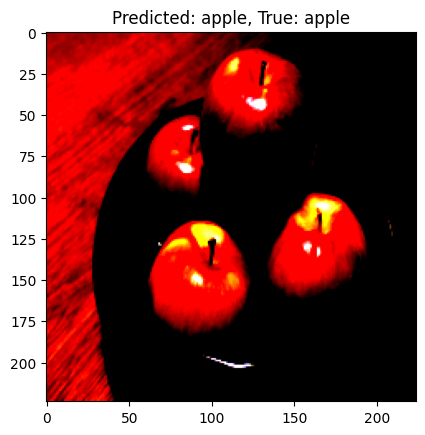

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


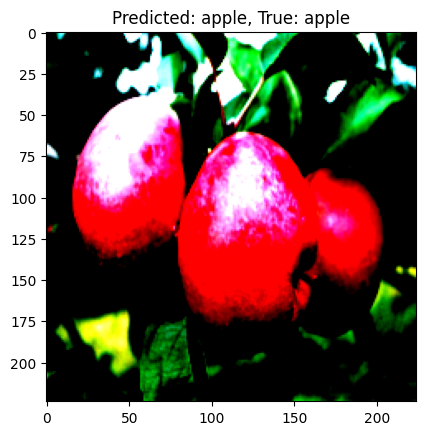

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.64].


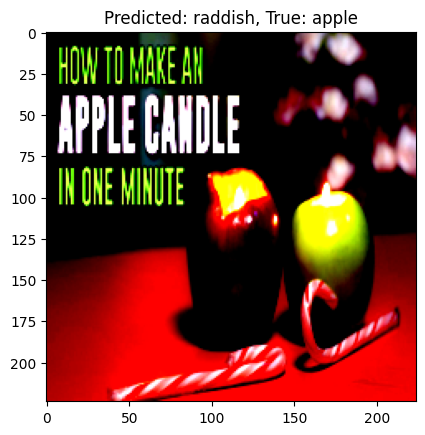

In [14]:
import matplotlib.pyplot as plt
import torchvision

for i in range(10):
    img, label = test_dataset_stage2[i]
    plt.imshow(img.permute(1, 2, 0))  # convert from CHW to HWC
    plt.title(f"Predicted: {train_dataset_stage2.classes[y_final_pred[i]]}, True: {train_dataset_stage2.classes[label]}")
    plt.show()
